In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools
from tools import reg_ts
from tools import sharpe_ratio_ts
from scipy.stats import rankdata

In [2]:
pro = ts.pro_api()

In [3]:
#获取行业分类
industrys = DP.get_industrys(level='L1')

In [4]:
#industry = ['801010.SI', '801080.SI', '801120.SI', '801150.SI', '801740.SI', '801750.SI', '801760.SI' '801770.SI',]
industry = ['801750.SI']
#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'vol',
                                 'amount',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'dv_ttm',
                                 'total_mv',
                                 'st',])

money_dic = DP.get_stock_money_data(industrys, industry)
for k in money_dic.keys():
    money_dic[k] = DataFrame(money_dic[k], index=data['open'].index, columns=data['open'].columns)

In [5]:
st = data['st'].fillna(False)

In [6]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

vol = data['vol'] * 100
amount = data['amount'] * 1000

vwap = (amount / vol * data['adj_factor']).fillna(method='ffill')
vwap = np.log(vwap)

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

dv = data['dv_ttm']

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

In [7]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [8]:
r1 = ror
r2 = ror.rolling(3).sum()
r3 = ror.rolling(5).sum()
r4 = ror.rolling(10).sum()
r5 = ror.rolling(15).sum()

In [9]:
x1 = r_rinei
x2 = r_rinei.rolling(3).sum()
x3 = r_rinei.rolling(5).sum()
x4 = r_rinei.rolling(10).sum()
x5 = r_rinei.rolling(15).sum()

In [10]:
z1 = r_geye
z2 = r_geye.rolling(3).sum()
z3 = r_geye.rolling(5).sum()
z4 = r_geye.rolling(10).sum()
z5 = r_geye.rolling(15).sum()

In [11]:
m1 = np.exp(CLOSE)/np.exp(CLOSE).rolling(3).mean()
m2 = np.exp(CLOSE)/np.exp(CLOSE).rolling(5).mean()
m3 = np.exp(CLOSE)/np.exp(CLOSE).rolling(10).mean()
m4 = np.exp(CLOSE)/np.exp(CLOSE).rolling(15).mean()
m5 = np.exp(CLOSE)/np.exp(CLOSE).rolling(20).mean()

In [12]:
h1 = rh
h2 = rh.rolling(3).sum()
h3 = rh.rolling(5).sum()
h4 = rh.rolling(10).sum()
h5 = rh.rolling(15).sum()

In [13]:
l1 = rl
l2 = rl.rolling(3).sum()
l3 = rl.rolling(5).sum()
l4 = rl.rolling(10).sum()
l5 = rl.rolling(15).sum()

In [14]:
vr1 = vr
vr2 = vr.rolling(3).sum()
vr3 = vr.rolling(5).sum()
vr4 = vr.rolling(10).sum()
vr5 = vr.rolling(15).sum()

In [15]:
rzrq1 = d_rzrq.fillna(0)
rzrq2 = d_rzrq.rolling(3).sum().fillna(0)
rzrq3 = d_rzrq.rolling(5).sum().fillna(0)
rzrq4 = d_rzrq.rolling(10).sum().fillna(0)
rzrq5 = d_rzrq.rolling(15).sum().fillna(0)

In [16]:
gt1 = d_gt.fillna(0)
gt2 = d_gt.rolling(3).sum().fillna(0)
gt3 = d_gt.rolling(5).sum().fillna(0)
gt4 = d_gt.rolling(10).sum().fillna(0)
gt5 = d_gt.rolling(15).sum().fillna(0)

In [17]:
ao = vwap-OPEN
ca = CLOSE-vwap

In [18]:
b_ts1, e_ts1 = reg_ts(CLOSE, 3)
b_ts2, e_ts2 = reg_ts(CLOSE, 5)
b_ts3, e_ts3 = reg_ts(CLOSE, 10)
b_ts4, e_ts4 = reg_ts(CLOSE, 15)
b_ts5, e_ts5 = reg_ts(CLOSE, 20)

In [19]:
sr1 = sharpe_ratio_ts(ror, 3)
sr2 = sharpe_ratio_ts(ror, 5)
sr3 = sharpe_ratio_ts(ror, 10)
sr4 = sharpe_ratio_ts(ror, 15)
sr5 = sharpe_ratio_ts(ror, 20)

In [20]:
w1 = (CLOSE - LOW.shift().rolling(3).min()) / (HIGH.shift().rolling(3).max() - LOW.shift().rolling(3).min()).fillna(0)
w2 = (CLOSE - LOW.shift().rolling(5).min()) / (HIGH.shift().rolling(5).max() - LOW.shift().rolling(5).min()).fillna(0)
w3 = (CLOSE - LOW.shift().rolling(10).min()) / (HIGH.shift().rolling(10).max() - LOW.shift().rolling(10).min()).fillna(0)
w4 = (CLOSE - LOW.shift().rolling(20).min()) / (HIGH.shift().rolling(20).max() - LOW.shift().rolling(20).min()).fillna(0)
w5 = (CLOSE - LOW.shift().rolling(40).min()) / (HIGH.shift().rolling(40).max() - LOW.shift().rolling(40).min()).fillna(0)

In [21]:
def reg(y, x, n):
    lxx = (x**2).rolling(n).sum() - n * (x.rolling(n).mean()**2)
    lxy = (x * y).rolling(n).sum() - n * x.rolling(n).mean() * y.rolling(n).mean()
    b = lxy / lxx
    a = y.rolling(n).mean() - b * x.rolling(n).mean()

    return a, b
    
r_market = ror.mean(1)

a_dic = {}
b_dic = {}
sd_dic = {}
sk_dic = {}
ku_dic = {}

#回归天数
n_regs = [3, 5, 10, 15, 20]
tmp = {k:ror.mean(1) for k in industrys[industry[0]]}
for n_reg in n_regs:
    a, b = reg(DataFrame(ror), DataFrame(tmp), n_reg)
    e = DataFrame(ror) - a - b * DataFrame(tmp)

    a = a
    b = b
    sd = e.rolling(n_reg).std()

    sk = e.rolling(n_reg).skew()
    ku = e.rolling(n_reg).kurt()
    a_dic[n_reg] = a
    b_dic[n_reg] = b
    sd_dic[n_reg] = sd
    sk_dic[n_reg] = sk
    ku_dic[n_reg] = ku
a1 = a_dic[n_regs[0]]
a2 = a_dic[n_regs[1]]
a3 = a_dic[n_regs[2]]
a4 = a_dic[n_regs[3]]
a5 = a_dic[n_regs[4]]
b1 = b_dic[n_regs[0]]
b2 = b_dic[n_regs[1]]
b3 = b_dic[n_regs[2]]
b4 = b_dic[n_regs[3]]
b5 = b_dic[n_regs[4]]
sd1 = sd_dic[n_regs[0]]
sd2 = sd_dic[n_regs[1]]
sd3 = sd_dic[n_regs[2]]
sd4 = sd_dic[n_regs[3]]
sd5 = sd_dic[n_regs[4]]
sk1 = sk_dic[n_regs[0]]
sk2 = sk_dic[n_regs[1]]
sk3 = sk_dic[n_regs[2]]
sk4 = sk_dic[n_regs[3]]
sk5 = sk_dic[n_regs[4]]
ku1 = ku_dic[n_regs[0]]
ku2 = ku_dic[n_regs[1]]
ku3 = ku_dic[n_regs[2]]
ku4 = ku_dic[n_regs[3]]
ku5 = ku_dic[n_regs[4]]

In [22]:
lj1 = r_rinei.rolling(3).sum() * (1-ltrf.rolling(3).corr(CLOSE))
lj2 = r_rinei.rolling(5).sum() * (1-ltrf.rolling(5).corr(CLOSE))
lj3 = r_rinei.rolling(10).sum() * (1-ltrf.rolling(10).corr(CLOSE))
lj4 = r_rinei.rolling(15).sum() * (1-ltrf.rolling(15).corr(CLOSE))
lj5 = r_rinei.rolling(20).sum() * (1-ltrf.rolling(20).corr(CLOSE))

In [23]:
factor_raw = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'w1':w1, 'w2':w2, 'w3':w3, 'w4':w4, 'w5':w5, 
    'sr1':sr1, 'sr2':sr2, 'sr3':sr3, 'sr4':sr4, 'sr5':sr5, 
    'lj1':lj1, 'lj2':lj2, 'lj3':lj3, 'lj4':lj4, 'lj5':lj5, 
    'ao':ao,
    'ca':ca,
    'pe':pe, 'pb':pb, 'ps':ps, 'dv':dv, 'lmv':lmv,
    'ao':ao, 'ca':ca,
    'b_ts1':b_ts1, 'b_ts2':b_ts2, 'b_ts3':b_ts3, 'b_ts4':b_ts4, 'b_ts5':b_ts5, 
    'e_ts1':e_ts1, 'e_ts2':e_ts2, 'e_ts3':e_ts3, 'e_ts4':e_ts4, 'e_ts5':e_ts5, 
    'a1':a1, 'a2':a2, 'a3':a3, 'a4':a4, 'a5':a5, 
    'b1':b1, 'b2':b2, 'b3':b3, 'b4':b4, 'b5':b5, 
    'sd1':sd1, 'sd2':sd2, 'sd3':sd3, 'sd4':sd4, 'sd5':sd5, 
    'sk1':sk1, 'sk2':sk2, 'sk3':sk3, 'sk4':sk4, 'sk5':sk5, 
    'ku1':ku1, 'ku2':ku2, 'ku3':ku3, 'ku4':ku4, 'ku5':ku5, 
}

In [24]:
for k in factor_raw.keys():
    df = DataFrame(factor_raw[k])
    df[st] = DataFrame({col:df.mean(1) for col in df.columns})
    df = standardize(df)
    #df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    #factor[k] = DataFrame(rankdata(df.fillna(0), method='average', axis=1), index=df.index, columns=df.columns)
    factor_raw[k] = DataFrame(df)

In [25]:
n = 2
y_raw = CLOSE.shift(-n+1)-OPEN
y = DataFrame(y_raw)
y[st] = DataFrame({col:y.mean(1) for col in y.columns})
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = DataFrame({col:y.mean(1) for col in y.columns})
y = standardize(y)

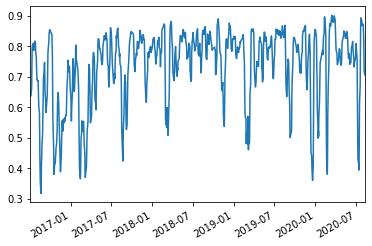

In [470]:
ic, ir = tools.icir(m4.shift().iloc[-1000:,:], w3.shift().iloc[-1000:,:], n=20)
ic.rolling(5).mean().plot()
#statsmodels.graphics.tsaplots.plot_acf(ic)

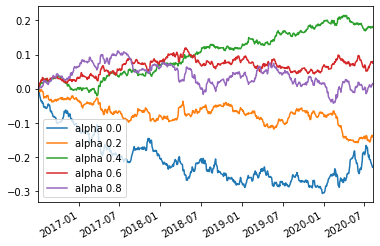

In [237]:
tools.group_backtest(pb.shift().iloc[-1000:,:], (y_raw / n).iloc[-1000:,:], n=5)

In [26]:
factor_list = ['ca',
               'lj2',
               'a2', 'b2', 'sd3', 'sk3',
               'pe',
               'lmv']
formula = 'y~' + '+'.join(factor_list)
factor = {k:factor_raw[k] for k in factor_list}

In [27]:
begin_date = '2017-01-01'
split_date = '2019-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]
df_y_train = DataFrame({'y':y.loc[train_date, :].fillna(0).values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].fillna(0).values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [28]:
#df_train.corr()

In [29]:
model = smf.glm(formula, data=df_train).fit()
model.tvalues

Intercept   -2.433136e-15
ca          -1.254967e+01
lj2         -1.785775e+00
a2          -2.935225e+00
b2           1.270351e+01
sd3         -5.779659e+00
sk3         -2.867843e+00
pe           4.581689e+00
lmv         -1.848024e+00
dtype: float64

603660.SH    0.277732
300730.SZ    0.181890
002766.SZ    0.180298
300167.SZ    0.166416
300550.SZ    0.146980
300096.SZ    0.140402
300150.SZ    0.130241
300386.SZ    0.129181
000606.SZ    0.121684
300674.SZ    0.120947
Name: 2018-12-28 00:00:00, dtype: float64


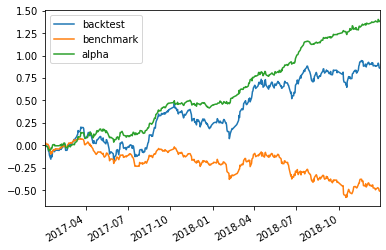

In [30]:
#调仓周期
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
num_stock = 5
q = 1 - num_stock / len(y.columns)
position = y_hat.ge(y_hat.quantile(q, 1), 0)
position.iloc[0, :]=False

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * y_raw.loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300455.SZ    0.172409
300462.SZ    0.105408
002987.SZ    0.099489
300440.SZ    0.098460
300687.SZ    0.089858
600850.SH    0.087405
300369.SZ    0.084105
300532.SZ    0.080537
300330.SZ    0.079027
002401.SZ    0.078995
Name: 2020-08-13 00:00:00, dtype: float64


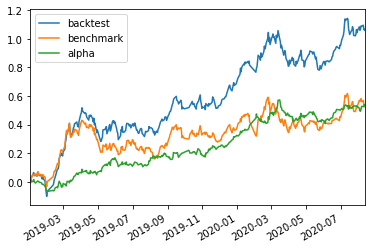

In [31]:
#调仓周期
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
num_stock = 5
q = 1 - num_stock / len(y.columns)
position = y_hat.ge(y_hat.quantile(q, 1), 0)
position.iloc[0, :]=False

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * y_raw.loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [32]:
alpha.mean() / alpha.std() * np.sqrt(len(ror_huice))

2.266758440336519

In [33]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].fillna(0).values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

002232.SZ    0.275068
300552.SZ    0.133317
300462.SZ    0.129121
300330.SZ    0.119271
300150.SZ    0.113299
300379.SZ    0.100363
300687.SZ    0.094889
300440.SZ    0.086073
300339.SZ    0.081852
300465.SZ    0.081354
Name: 2020-08-13 00:00:00, dtype: float64


In [34]:
data['close'].loc[data['close'].index[-1],y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10].index] * 1.1

002232.SZ    16.544
300552.SZ    50.523
300462.SZ    27.500
300330.SZ    12.397
300150.SZ     5.346
300379.SZ    48.477
300687.SZ    22.165
300440.SZ    10.120
300339.SZ    12.672
300465.SZ    16.907
Name: 2020-08-13 00:00:00, dtype: float64

In [259]:
model_gbdt = GradientBoostingRegressor().fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
feture_importances_gbdt = Series(model_gbdt.feature_importances_, index=factor.keys())
feture_importances_gbdt.sort_values(ascending=False).iloc[:20]

ca       0.191673
x3       0.147145
b2       0.141685
m4       0.109186
lmv      0.080601
lj1      0.077674
e_ts1    0.072098
sd3      0.053208
pe       0.051629
lj2      0.048664
sk3      0.026436
dtype: float64

In [230]:
model_rf = RandomForestRegressor().fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
feture_importances_rf = Series(model_rf.feature_importances_, index=factor.keys())
feture_importances_rf.sort_values(ascending=False).iloc[:20]

ca       0.069279
e_ts1    0.064575
pb       0.064177
lmv      0.062956
sd3      0.062518
b2       0.061826
m4       0.061030
ps       0.060814
x3       0.057201
lj1      0.057170
a2       0.056308
w3       0.055847
pe       0.055396
sk3      0.054586
b_ts2    0.054387
lj2      0.052472
dv       0.049459
dtype: float64

In [747]:
begin_date = '2017-01-01'
split_date = '2019-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]
df_y_train = DataFrame({'y':y.loc[train_date, :].fillna(0).values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].fillna(0).values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [839]:
model = LinearRegression()

In [829]:
model = MLPRegressor(random_state=12, max_iter=1000, hidden_layer_sizes=(8,3))

In [877]:
model = GradientBoostingRegressor(max_depth=1)

In [799]:
model = RandomForestRegressor(n_estimators=50, min_samples_leaf=6666, n_jobs=-1)

In [891]:
model = svm.LinearSVR(random_state=233, max_iter=2000)

In [892]:
model.fit(df_x_train, df_y_train.y)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=2000,
          random_state=233, tol=0.0001, verbose=0)

603660.SH    0.226273
300730.SZ    0.150002
002766.SZ    0.136604
300462.SZ    0.130613
300674.SZ    0.130506
300096.SZ    0.124929
300550.SZ    0.121990
300386.SZ    0.116920
300687.SZ    0.113004
300167.SZ    0.109199
Name: 2018-12-28 00:00:00, dtype: float64


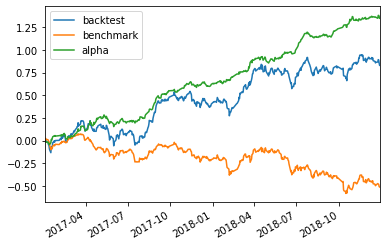

In [893]:
#调仓周期
y_hat = DataFrame(model.predict(df_x_train).reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
num_stock = 5
q = 1 - num_stock / len(y.columns)
position = y_hat.ge(y_hat.quantile(q, 1), 0)
position.iloc[0, :]=False

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300496.SZ    0.141619
300579.SZ    0.140816
300552.SZ    0.107398
300738.SZ    0.088887
300045.SZ    0.086418
300730.SZ    0.085806
300366.SZ    0.083725
300768.SZ    0.076035
300365.SZ    0.075766
300229.SZ    0.075281
Name: 2020-08-10 00:00:00, dtype: float64


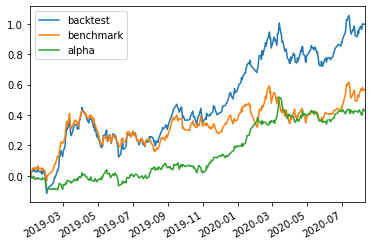

In [894]:
#调仓周期
y_hat = DataFrame(model.predict(df_x_test).reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
num_stock = 5
q = 1 - num_stock / len(y.columns)
position = y_hat.ge(y_hat.quantile(q, 1), 0)
position.iloc[0, :]=False

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [895]:
alpha.mean() / alpha.std() * np.sqrt(len(ror_huice))

1.7051404318326147

In [844]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].fillna(0).values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2.iloc[:, 1:]).reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300047.SZ    0.107891
300552.SZ    0.101972
300045.SZ    0.100373
300177.SZ    0.096943
002153.SZ    0.087479
300379.SZ    0.085908
300330.SZ    0.084094
300339.SZ    0.083989
300369.SZ    0.082806
300462.SZ    0.081579
Name: 2020-08-10 00:00:00, dtype: float64


In [229]:
print(y_hat2.iloc[-2,:].sort_values(ascending=False).dropna().iloc[:10])

300496.SZ    0.317393
300738.SZ    0.165922
300579.SZ    0.165624
600476.SH    0.135859
300380.SZ    0.116491
002316.SZ    0.104166
300532.SZ    0.104043
300010.SZ    0.101281
300807.SZ    0.098797
300588.SZ    0.098535
Name: 2020-08-07 00:00:00, dtype: float64
